In [6]:
# 1. Import Libraries and Setup Device
import os
# Fix OpenMP conflict error (OMP: Error #15)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torch.optim import AdamW
import sys
import numpy as np
from PIL import Image

# Add current directory to path to import loader
sys.path.append(os.getcwd())
from ouhands_loader import OuhandsDS

# Setup Device
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

Using device: cuda


In [7]:
# 2. Define Dual-View Dataset

class DualViewOuhandsDS(Dataset):
    """
    Wraps OuhandsDS to return two views of the image:
    1. Global View: Full image resized to 224x224
    2. Local View: Image cropped to BBox and resized to 224x224
    """
    def __init__(self, split='train', root_dir=r'D:\Courses\Csc2503\proj\archive'):
        # Initialize base dataset with bbox loading enabled
        self.base_ds = OuhandsDS(
            root_dir=root_dir,
            split=split,
            use_bounding_box=True,
            crop_to_bbox=False, # We handle cropping manually
            transform=lambda x: x # Return PIL Image directly (disable default ToTensor)
        )
        
        # Standard ImageNet normalization
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        # Transform for Global View
        self.global_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            self.normalize
        ])
        
        # Transform for Local View (Crop is done before this)
        self.local_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            self.normalize
        ])

    def __len__(self):
        return len(self.base_ds)

    def __getitem__(self, idx):
        # Get raw data from base dataset
        # Returns: (image, label, bbox)
        image, label, bbox = self.base_ds[idx]
        
        # 1. Global View
        global_img = self.global_transform(image)
        
        # Generate Mask for Global View (for Attention Loss)
        # Mask should be 1 inside bbox, 0 outside
        mask = torch.zeros((224, 224), dtype=torch.float32)
        if bbox is not None:
            x, y, w, h = bbox
            # Scale to 224x224
            scale_x = 224 / image.width
            scale_y = 224 / image.height
            
            x1 = int(x * scale_x)
            y1 = int(y * scale_y)
            x2 = int((x + w) * scale_x)
            y2 = int((y + h) * scale_y)
            
            # Clamp
            x1 = max(0, x1); y1 = max(0, y1)
            x2 = min(224, x2); y2 = min(224, y2)
            
            mask[y1:y2, x1:x2] = 1.0
        
        # 2. Local View (Crop to BBox)
        # bbox is (x, y, w, h)
        if bbox is not None:
            # Use the helper from OuhandsDS (accessed via instance method if possible, or manually)
            # We can just use the logic: crop(x, y, x+w, y+h)
            x, y, w, h = bbox
            # Add some padding as in the original loader
            padding = 20
            x_min = max(0, x - padding)
            y_min = max(0, y - padding)
            x_max = min(image.width, x + w + padding)
            y_max = min(image.height, y + h + padding)
            
            local_crop = image.crop((x_min, y_min, x_max, y_max))
        else:
            # Fallback if no bbox: use full image
            local_crop = image
            
        local_img = self.local_transform(local_crop)
        
        return global_img, local_img, label, mask

# Create Datasets
train_ds = DualViewOuhandsDS(split='train')
val_ds = DualViewOuhandsDS(split='validation')
test_ds = DualViewOuhandsDS(split='test')

# Create DataLoaders
batch_size = 32
num_workers = 0 
pin_memory = False

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

print(f"Train size: {len(train_ds)}")
print(f"Val size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")

Loaded 1600 samples for train split
Class distribution: {'A': 160, 'B': 160, 'C': 160, 'D': 160, 'E': 160, 'F': 160, 'H': 160, 'I': 160, 'J': 160, 'K': 160}
Loaded 400 samples for validation split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}
Loaded 1000 samples for test split
Class distribution: {'A': 100, 'B': 100, 'C': 100, 'D': 100, 'E': 100, 'F': 100, 'H': 100, 'I': 100, 'J': 100, 'K': 100}
Train size: 1600
Val size: 400
Test size: 1000


In [8]:
# DEBUG: Test Data Loading Speed
import time

print("Testing data loading speed...")
t0 = time.time()
try:
    # Fetch one batch
    print("Attempting to load first batch...")
    batch = next(iter(train_loader))
    t1 = time.time()
    print(f"Successfully loaded one batch in {t1-t0:.2f} seconds.")
    print(f"Global Image Shape: {batch[0].shape}")
    print(f"Local Image Shape: {batch[1].shape}")
    print(f"Labels Shape: {batch[2].shape}")
    print(f"Masks Shape: {batch[3].shape}")
except Exception as e:
    print(f"Error loading batch: {e}")
    import traceback
    traceback.print_exc()

Testing data loading speed...
Attempting to load first batch...
Successfully loaded one batch in 1.03 seconds.
Global Image Shape: torch.Size([32, 3, 224, 224])
Local Image Shape: torch.Size([32, 3, 224, 224])
Labels Shape: torch.Size([32])
Masks Shape: torch.Size([32, 224, 224])
Successfully loaded one batch in 1.03 seconds.
Global Image Shape: torch.Size([32, 3, 224, 224])
Local Image Shape: torch.Size([32, 3, 224, 224])
Labels Shape: torch.Size([32])
Masks Shape: torch.Size([32, 224, 224])


In [9]:
# 3. Define Dual-Stream DINO Model

class DualDINOModel(nn.Module):
    def __init__(self, num_classes=10, freeze_backbone=False):
        super(DualDINOModel, self).__init__()
        
        # Load DINO ViT-S/16 backbone
        # Using torch.hub as in previous experiments
        print("Loading DINO ViT-S/16 backbone...")
        self.backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("Backbone frozen.")
            
        # Embed dim for ViT-S/16 is 384
        embed_dim = 384
        
        # Fusion: Concatenate Global (384) + Local (384) = 768
        self.fusion_dim = embed_dim * 2
        
        self.classifier = nn.Sequential(
            nn.Linear(self.fusion_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, global_img, local_img, return_attn=False):
        # Extract features
        # DINO forward returns class token by default
        global_feat = self.backbone(global_img) # (B, 384)
        local_feat = self.backbone(local_img)   # (B, 384)
        
        # Fuse
        fused = torch.cat([global_feat, local_feat], dim=1) # (B, 768)
        
        # Classify
        logits = self.classifier(fused)
        
        if return_attn:
            # Get attention map for global image
            # Shape: (B, nh, N, N)
            attentions = self.backbone.get_last_selfattention(global_img)
            return logits, attentions
        
        return logits

model = DualDINOModel(num_classes=10).to(device)
print(model)

Loading DINO ViT-S/16 backbone...


Using cache found in C:\Users\24912/.cache\torch\hub\facebookresearch_dino_main


DualDINOModel(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): La

In [10]:
# 4. Training Loop

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

def attention_loss_fn(attentions, masks):
    """
    Computes loss to penalize attention outside the bounding box.
    attentions: (B, nh, N, N) output from get_last_selfattention
    masks: (B, 224, 224) binary mask (1 inside bbox, 0 outside)
    """
    # 1. Extract CLS attention to patches
    # attentions shape: (B, nh, 1+num_patches, 1+num_patches)
    # We want row 0 (CLS token), columns 1: (patches)
    # Shape: (B, nh, num_patches)
    cls_attn = attentions[:, :, 0, 1:] 
    
    # 2. Reshape to 2D map
    B, nh, num_patches = cls_attn.shape
    h_feat = int(np.sqrt(num_patches)) # 14 for 224 img / 16 patch
    cls_attn = cls_attn.reshape(B, nh, h_feat, h_feat)
    
    # 3. Average over heads
    cls_attn = cls_attn.mean(dim=1) # (B, 14, 14)
    
    # 4. Downsample Mask to Feature Map size (14x14)
    # masks is (B, 224, 224) -> (B, 1, 224, 224)
    masks_resized = torch.nn.functional.interpolate(
        masks.unsqueeze(1), 
        size=(h_feat, h_feat), 
        mode='nearest'
    ).squeeze(1) # (B, 14, 14)
    
    # 5. Calculate Loss
    # We want to penalize attention outside the mask
    # Outside mask: (1 - masks_resized) is 1
    # Penalty = Attention * (1 - Mask)
    # Normalize by total attention to keep scale consistent
    loss = (cls_attn * (1 - masks_resized)).sum() / (cls_attn.sum() + 1e-6)
    
    return loss

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_cls_loss = 0.0
    running_attn_loss = 0.0
    correct = 0
    total = 0
    
    # Add a counter to debug progress
    for i, (global_img, local_img, labels, masks) in enumerate(tqdm(loader, desc="Training")):
        if i == 0:
            print("First batch loaded, starting forward pass...")
            
        global_img = global_img.to(device)
        local_img = local_img.to(device)
        labels = labels.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass with attention
        logits, attentions = model(global_img, local_img, return_attn=True)
        
        # 1. Classification Loss
        loss_cls = criterion(logits, labels)
        
        # 2. Attention Loss
        loss_attn = attention_loss_fn(attentions, masks)
        
        # Total Loss (Weight attention loss)
        beta = 0.5 # Weight for attention loss
        loss = loss_cls + beta * loss_attn
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)
        running_cls_loss += loss_cls.item() * labels.size(0)
        running_attn_loss += loss_attn.item() * labels.size(0)
        
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / total
    epoch_cls = running_cls_loss / total
    epoch_attn = running_attn_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_cls, epoch_attn, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for global_img, local_img, labels, _ in tqdm(loader, desc="Evaluating"):
            global_img = global_img.to(device)
            local_img = local_img.to(device)
            labels = labels.to(device)
            
            outputs = model(global_img, local_img)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    return running_loss / total, 100. * correct / total

# Run Training
num_epochs = 5
best_acc = 0.0

print("Starting training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_loss, train_cls, train_attn, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    scheduler.step()
    
    print(f"Train Loss: {train_loss:.4f} (Cls: {train_cls:.4f}, Attn: {train_attn:.4f}) | Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_dual_dino_model.pth")
        print("Saved Best Model!")

print(f"Training Complete. Best Val Acc: {best_acc:.2f}%")

Starting training...
Epoch 1/5


Training:   0%|          | 0/50 [00:00<?, ?it/s]

First batch loaded, starting forward pass...


Evaluating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]



Train Loss: 0.9963 (Cls: 0.9431, Attn: 0.1063) | Acc: 76.44%
Val Loss: 0.3103 | Acc: 92.50%
Saved Best Model!
Epoch 2/5


Training:   0%|          | 0/50 [00:00<?, ?it/s]

First batch loaded, starting forward pass...


Evaluating: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]



Train Loss: 0.1233 (Cls: 0.1205, Attn: 0.0056) | Acc: 99.06%
Val Loss: 0.0824 | Acc: 99.50%
Saved Best Model!
Epoch 3/5


Training:   0%|          | 0/50 [00:00<?, ?it/s]

First batch loaded, starting forward pass...


Evaluating: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]



Train Loss: 0.0330 (Cls: 0.0322, Attn: 0.0014) | Acc: 100.00%
Val Loss: 0.0320 | Acc: 100.00%
Saved Best Model!
Epoch 4/5


Training:   0%|          | 0/50 [00:00<?, ?it/s]

First batch loaded, starting forward pass...


Evaluating: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Train Loss: 0.0237 (Cls: 0.0235, Attn: 0.0005) | Acc: 100.00%
Val Loss: 0.0319 | Acc: 99.75%
Epoch 5/5


Training:   0%|          | 0/50 [00:00<?, ?it/s]

First batch loaded, starting forward pass...


Evaluating: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]

Train Loss: 0.0178 (Cls: 0.0176, Attn: 0.0003) | Acc: 100.00%
Val Loss: 0.0199 | Acc: 100.00%
Training Complete. Best Val Acc: 100.00%


In [11]:
# 5. Final Evaluation & Metrics
from sklearn.metrics import f1_score

# Load best model
if os.path.exists("best_dual_dino_model.pth"):
    model.load_state_dict(torch.load("best_dual_dino_model.pth"))
    print("Loaded best model.")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for global_img, local_img, labels, _ in tqdm(test_loader, desc="Testing"):
        global_img = global_img.to(device)
        local_img = local_img.to(device)
        outputs = model(global_img, local_img)
        _, preds = outputs.max(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

test_acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
test_f1 = f1_score(all_labels, all_preds, average='macro')

# Params & FLOPs
params_m = sum(p.numel() for p in model.parameters()) / 1e6

flops_g = "N/A"
try:
    from thop import profile
    dummy_global = torch.randn(1, 3, 224, 224).to(device)
    dummy_local = torch.randn(1, 3, 224, 224).to(device)
    flops, _ = profile(model, inputs=(dummy_global, dummy_local), verbose=False)
    flops_g = flops / 1e9
except ImportError:
    print("Install thop for FLOPs: pip install thop")

print("\n" + "="*30)
print(f"FINAL RESULTS (Dual-View DINO)")
print("="*30)
print(f"{'Metric':<15} | {'Value':<10}")
print("-" * 30)
print(f"{'Top-1 Acc (%)':<15} | {test_acc:.2f}")
print(f"{'Macro-F1':<15} | {test_f1:.4f}")
print(f"{'Params (M)':<15} | {params_m:.2f}")
print(f"{'FLOPs (G)':<15} | {flops_g if isinstance(flops_g, str) else f'{flops_g:.2f}'}")
print("="*30)

C:\Users\24912\AppData\Local\Temp\ipykernel_20340\2743700934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_dual_dino_model.pth")

Loaded best model.


Testing: 100%|██████████| 32/32 [00:44<00:00,  1.39s/it]




FINAL RESULTS (Dual-View DINO)
Metric          | Value     
------------------------------
Top-1 Acc (%)   | 88.70
Macro-F1        | 0.8868
Params (M)      | 22.07
FLOPs (G)       | 8.50


Visualizing attention maps for 10 random test images...



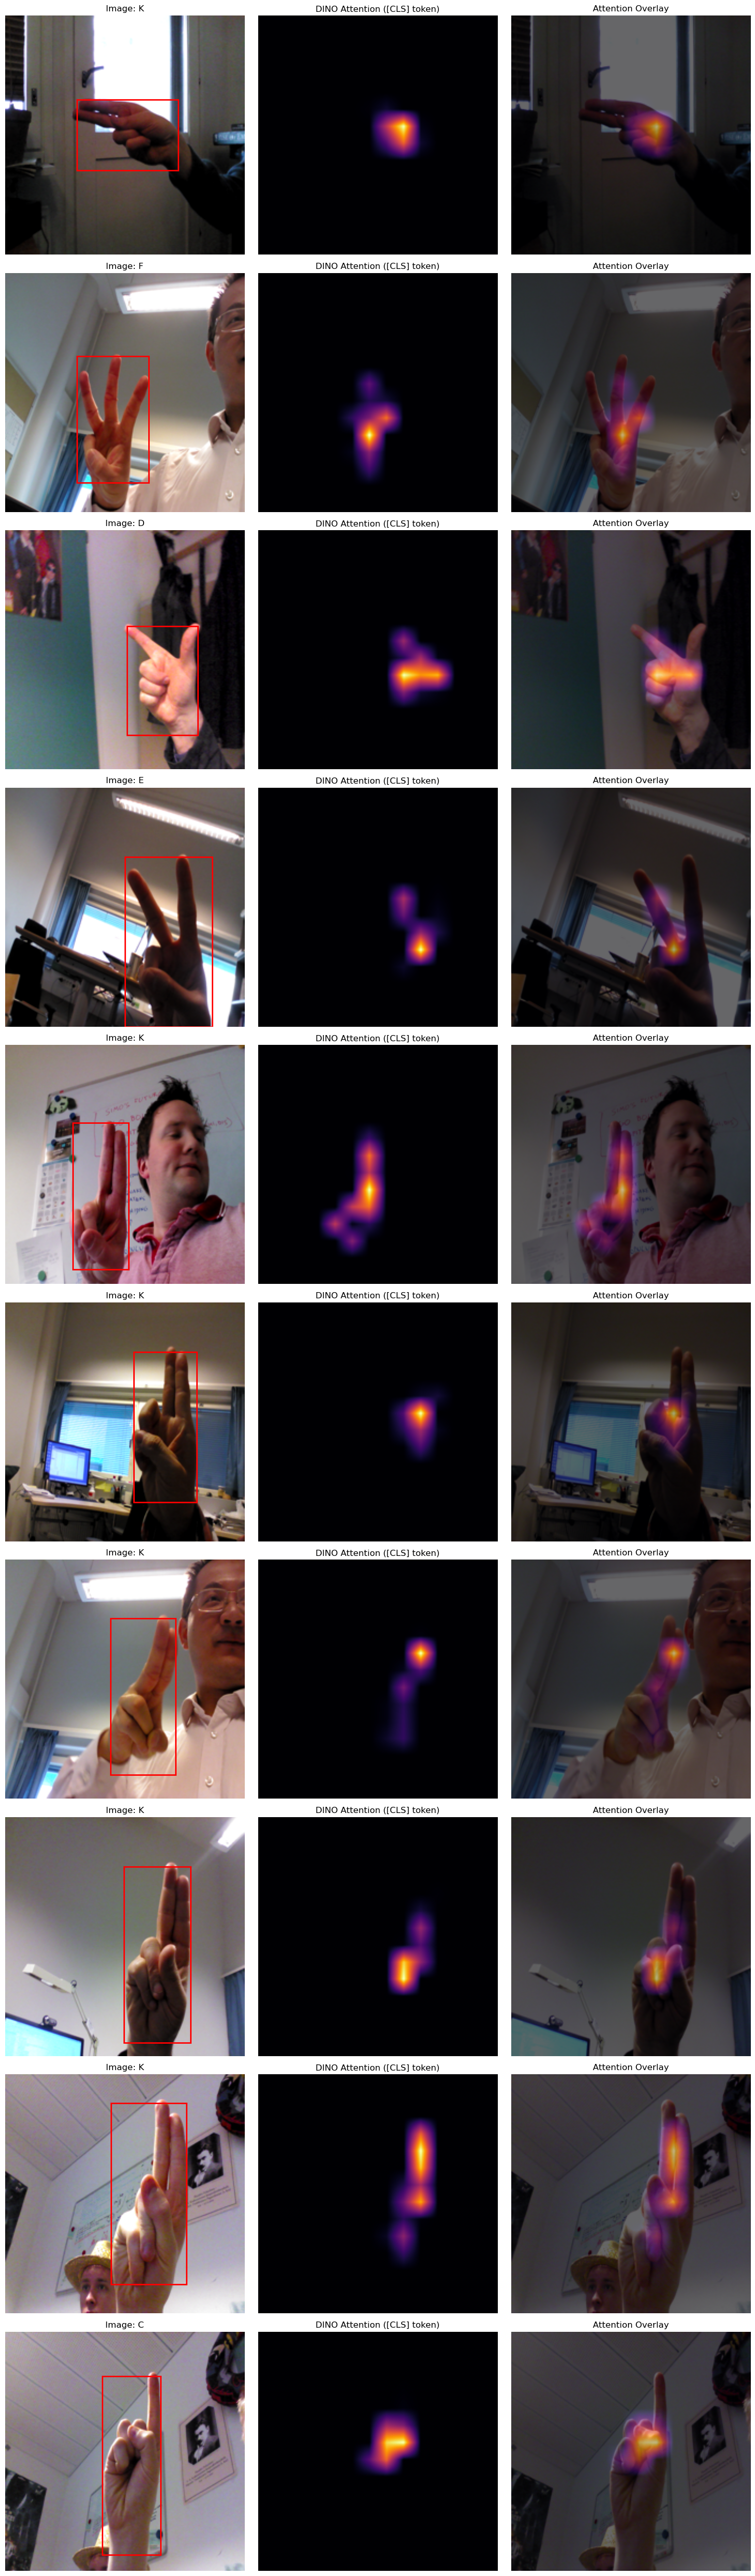

In [12]:
# 6. Visualize Attention Maps
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches

def visualize_attention(model, dataset, num_samples=10, device=device):
    """
    Visualizes the attention maps of the DINO backbone on the Global View.
    """
    model.eval()
    
    # Select random samples
    indices = random.sample(range(len(dataset)), num_samples)
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
        
    print(f"Visualizing attention maps for {num_samples} random test images...")
    
    for i, idx in enumerate(indices):
        # 1. Get data
        # dataset[idx] returns (global_tensor, local_tensor, label, mask)
        global_tensor, _, label_idx, _ = dataset[idx]
        
        # Get original PIL image and bbox for display
        # dataset.base_ds[idx] returns (pil_image, label, bbox)
        orig_img, _, bbox = dataset.base_ds[idx]
        class_name = dataset.base_ds.get_class_name(label_idx)
        
        # 2. Get Attention Map from Backbone
        # We use the global_tensor to see if the model attends to the hand in the full image
        img_input = global_tensor.unsqueeze(0).to(device)
        
        with torch.no_grad():
            # DINO ViT has a method get_last_selfattention
            # Output shape: (B, num_heads, N, N) where N = 1 + (H/p)*(W/p)
            attentions = model.backbone.get_last_selfattention(img_input)
            
        # 3. Process Attention
        # We look at the attention of the [CLS] token (index 0) to all patch tokens (indices 1:)
        nh = attentions.shape[1] # number of heads
        
        # Keep only the output of the CLS token
        # Shape: (1, nh, 1, N) -> (nh, N-1)
        attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
        
        # Reshape to 2D feature map
        # For 224x224 image and patch size 16, grid is 14x14
        w_featmap = h_featmap = int(np.sqrt(attentions.shape[-1]))
        attentions = attentions.reshape(nh, w_featmap, h_featmap)
        
        # Resize to original image size (224x224)
        # We use the global_transform's resize target which is 224x224
        attentions = nn.functional.interpolate(
            attentions.unsqueeze(0), 
            scale_factor=16, 
            mode="bilinear", 
            align_corners=False
        )[0].cpu().numpy()
        
        # Average attention across heads
        attn_mean = np.mean(attentions, axis=0)
        
        # 4. Plotting
        ax_orig = axes[i, 0]
        ax_attn = axes[i, 1]
        ax_over = axes[i, 2]
        
        # Original Image with BBox
        # Note: orig_img might be larger than 224x224, but global_tensor is 224x224.
        # For correct overlay, we should resize orig_img to 224x224 for display
        orig_img_resized = orig_img.resize((224, 224))
        
        ax_orig.imshow(orig_img_resized)
        ax_orig.set_title(f"Image: {class_name}")
        ax_orig.axis('off')
        
        # Draw BBox (need to scale if original image was not 224x224)
        if bbox is not None:
            # bbox is (x, y, w, h) in original image coordinates
            # Scale to 224x224
            scale_x = 224 / orig_img.width
            scale_y = 224 / orig_img.height
            rect = patches.Rectangle(
                (bbox[0]*scale_x, bbox[1]*scale_y), 
                bbox[2]*scale_x, 
                bbox[3]*scale_y, 
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax_orig.add_patch(rect)
            
        # Attention Map
        ax_attn.imshow(attn_mean, cmap='inferno')
        ax_attn.set_title("DINO Attention ([CLS] token)")
        ax_attn.axis('off')
        
        # Overlay
        ax_over.imshow(orig_img_resized)
        ax_over.imshow(attn_mean, cmap='inferno', alpha=0.6)
        ax_over.set_title("Attention Overlay")
        ax_over.axis('off')
        
    plt.tight_layout()
    plt.show()

# Run visualization
visualize_attention(model, test_ds, num_samples=10)